# Recipe rating prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


### Data import and train test split

In [2]:
try: # For kaggle
  train_pd = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')

  test_pd = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
  print('running on kaggle')
except: #for local machine 
  print('running on local machine')
  train_pd = pd.read_csv('data/train.csv')
  test_pd = pd.read_csv('data/test.csv')
  pass
copy_train_pd = train_pd.copy()
copy_test_pd = test_pd.copy()
train_pd.info()

X = train_pd.drop(['Rating'], axis= 1)
y = train_pd['Rating']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

running on local machine
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


### EDA(Exploratory Data Analysis)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  BestScore          13636 non-null  int64 
 13  Recipe_Review      13634 non-null  object
dtypes: int64(9), object(5)
memory usage: 1.5+ MB


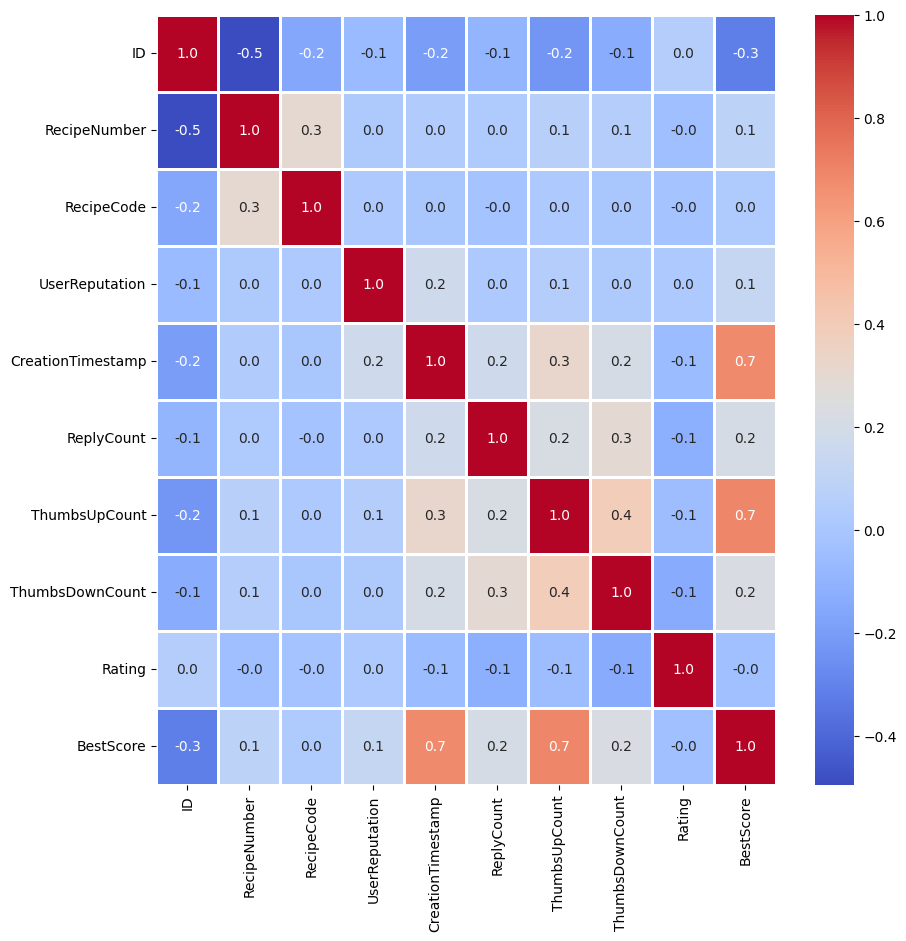

In [4]:
# plot correalation matrix using seaborn
plt.figure(figsize=(10,10))
sns.heatmap(train_pd.corr(numeric_only= True), annot=True, cmap='coolwarm', fmt='.1f', linewidths=1)
plt.show()

In [5]:
# seprate numeric and categorical features
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns
print('numeric_features: ', numeric_features)
print('categorical_features: ', categorical_features)

numeric_features:  Index(['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation',
       'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount',
       'BestScore'],
      dtype='object')
categorical_features:  Index(['RecipeName', 'CommentID', 'UserID', 'UserName', 'Recipe_Review'], dtype='object')


In [6]:
x_train_copy = x_train.copy()
x_test_copy = x_test.copy()
y_test_copy = y_test.copy()
y_train_copy = y_train.copy()


In [7]:
x_train.drop(categorical_features, axis=1, inplace=True)
x_test.drop(categorical_features, axis=1, inplace=True)

In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10908 entries, 3717 to 7270
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID                 10908 non-null  int64
 1   RecipeNumber       10908 non-null  int64
 2   RecipeCode         10908 non-null  int64
 3   UserReputation     10908 non-null  int64
 4   CreationTimestamp  10908 non-null  int64
 5   ReplyCount         10908 non-null  int64
 6   ThumbsUpCount      10908 non-null  int64
 7   ThumbsDownCount    10908 non-null  int64
 8   BestScore          10908 non-null  int64
dtypes: int64(9)
memory usage: 852.2 KB


In [9]:
from datetime import datetime
def convert_utc_to_datetime(utc:int) ->datetime:
    return datetime.utcfromtimestamp(utc)

def convert_dt_obj_to_datetime(df:pd.DataFrame, col_name:str):
    # df[col_name] = pd.to_datetime(df[col_name])
    df[col_name +'_Year'] = df[col_name].apply(lambda time: time.year)
    df[col_name +'_Month'] = df[col_name].apply(lambda time: time.month)
    df[col_name +'_Day'] = df[col_name].apply(lambda time: time.day)
    df[col_name +'_Hour'] = df[col_name].apply(lambda time: time.hour)

In [10]:
x_train['CreationTimestamp'] = x_train['CreationTimestamp'].apply(convert_utc_to_datetime)

In [11]:
x_test['CreationTimestamp'] = x_test['CreationTimestamp'].apply(convert_utc_to_datetime)
convert_dt_obj_to_datetime(x_test, 'CreationTimestamp')
x_test.drop('CreationTimestamp', axis=1, inplace=True)

In [12]:
convert_dt_obj_to_datetime(x_train, 'CreationTimestamp')
x_train.drop('CreationTimestamp', axis=1, inplace=True)

In [13]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10908 entries, 3717 to 7270
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ID                       10908 non-null  int64
 1   RecipeNumber             10908 non-null  int64
 2   RecipeCode               10908 non-null  int64
 3   UserReputation           10908 non-null  int64
 4   ReplyCount               10908 non-null  int64
 5   ThumbsUpCount            10908 non-null  int64
 6   ThumbsDownCount          10908 non-null  int64
 7   BestScore                10908 non-null  int64
 8   CreationTimestamp_Year   10908 non-null  int64
 9   CreationTimestamp_Month  10908 non-null  int64
 10  CreationTimestamp_Day    10908 non-null  int64
 11  CreationTimestamp_Hour   10908 non-null  int64
dtypes: int64(12)
memory usage: 1.1 MB


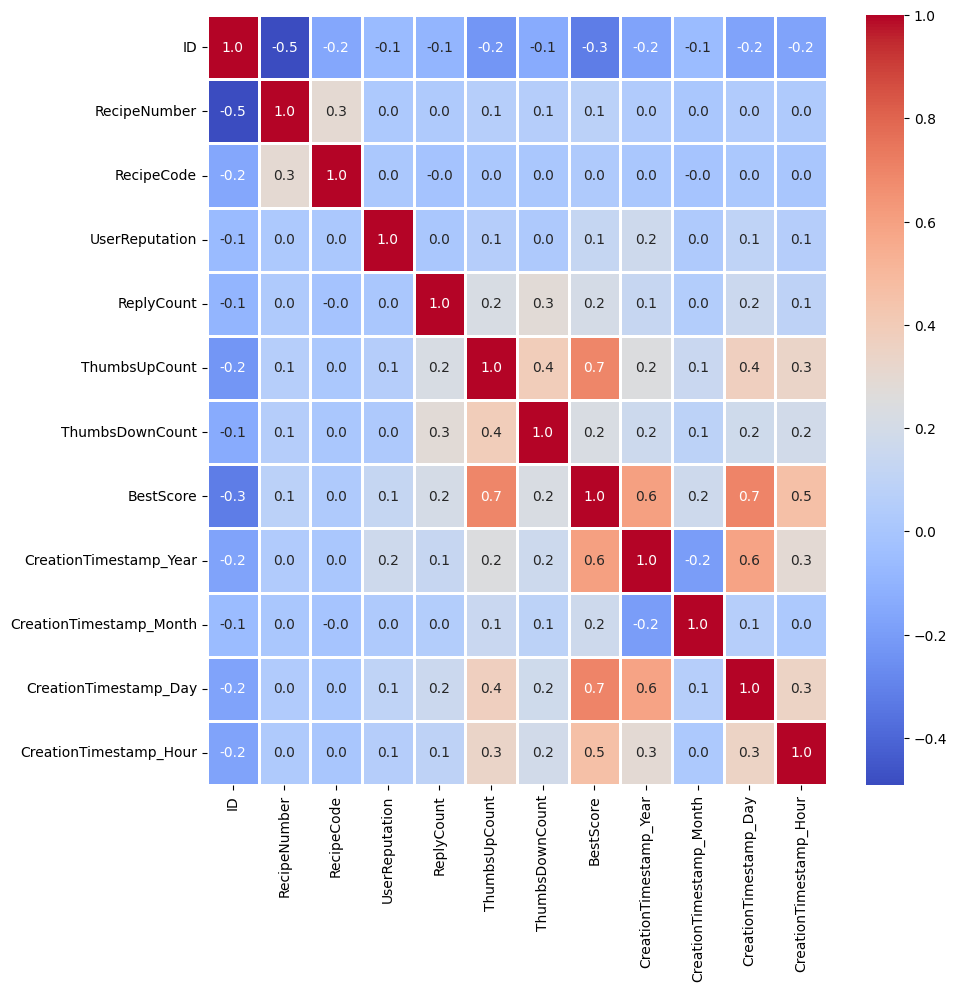

In [14]:
#plot correation matrix of x_train
plt.figure(figsize=(10,10))
sns.heatmap(x_train.corr(numeric_only= True), annot=True, cmap='coolwarm', fmt='.1f', linewidths=1)
plt.show()


In [15]:
# sns.pairplot(x_train)

In [16]:
x_train.describe()


,ID,RecipeNumber,RecipeCode,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,CreationTimestamp_Year,CreationTimestamp_Month,CreationTimestamp_Day,CreationTimestamp_Hour
count,10908.00000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000,10908.000000
mean,120.81784,38.478640,21735.732123,2.202787,0.014485,1.111661,0.542721,153.509993,2021.029428,6.014485,3.720572,10.646498
std,116.90480,29.608713,23818.884364,11.035792,0.135316,4.236109,3.194658,142.081460,0.169011,0.836266,3.623653,2.103556
min,0.00000,1.000000,386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.000000
25%,45.00000,12.000000,6504.000000,1.000000,0.000000,0.000000,0.000000,100.000000,2021.000000,6.000000,3.000000,10.000000
50%,91.00000,32.000000,14600.000000,1.000000,0.000000,0.000000,0.000000,100.000000,2021.000000,6.000000,3.000000,10.000000
75%,148.00000,63.000000,33121.000000,1.000000,0.000000,0.000000,0.000000,100.000000,2021.000000,6.000000,3.000000,11.000000
max,722.00000,100.000000,191775.000000,510.000000,3.000000,80.000000,126.000000,946.000000,2022.000000,12.000000,31.000000,23.000000


In [17]:
standart_scaler = StandardScaler()
pipeline = Pipeline(steps=[
  ('standart_scaler', standart_scaler),
  ('LogisticRegression', LogisticRegression())
  ])
pipeline.fit(x_train, y_train)

print(pipeline.score(x_train, y_train))

0.7637513751375138


In [18]:
y_pred = pipeline.predict(x_test)
accuracy = pipeline.score(x_test, y_test)
print('accuracy: ', accuracy)

accuracy:  0.7569648093841642


In [19]:
poly_pipe = Pipeline(steps=[
  ('poly', PolynomialFeatures(degree=2)),
  ('standart_scaler', standart_scaler),
  ('svc', SVC(kernel= 'linear'))
])
# poly_pipe.fit(x_train, y_train)
# print(poly_pipe.score(x_train, y_train))
# print(poly_pipe.score(x_test, y_test))


In [32]:
# features selection and model evaluation
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
# 95 % of variance
pca = PCA(n_components=0.95)
# 5 best features
select_k_best = SelectKBest(f_classif, k=5)
# random forest classifier
rfc = LogisticRegression()
# pipeline
pipeline = Pipeline(steps=[
  ('standart_scaler', standart_scaler),
  ('pca', pca),
  # ('select_k_best', select_k_best),
  # ('rfc', rfc)
  ('ridge', RidgeClassifier(alpha= 1.0))
])
pipeline.fit(x_train, y_train)
print(pipeline.score(x_train, y_train))
print(pipeline.score(x_test, y_test))


0.7632929959662633
0.7576979472140762


### submission code

In [21]:
test_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


In [22]:
submission_pd = test_pd.copy()
submission_pd.drop(categorical_features, axis=1, inplace=True)
submission_pd['CreationTimestamp'] = submission_pd['CreationTimestamp'].apply(convert_utc_to_datetime)
convert_dt_obj_to_datetime(submission_pd, 'CreationTimestamp')
submission_pd.drop('CreationTimestamp', axis=1, inplace=True)
submission_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ID                       4546 non-null   int64
 1   RecipeNumber             4546 non-null   int64
 2   RecipeCode               4546 non-null   int64
 3   UserReputation           4546 non-null   int64
 4   ReplyCount               4546 non-null   int64
 5   ThumbsUpCount            4546 non-null   int64
 6   ThumbsDownCount          4546 non-null   int64
 7   BestScore                4546 non-null   int64
 8   CreationTimestamp_Year   4546 non-null   int64
 9   CreationTimestamp_Month  4546 non-null   int64
 10  CreationTimestamp_Day    4546 non-null   int64
 11  CreationTimestamp_Hour   4546 non-null   int64
dtypes: int64(12)
memory usage: 426.3 KB


In [23]:
test_pd_prediction = pipeline.predict(submission_pd)

In [24]:
submission = pd.DataFrame(columns= ['ID', "Rating"])
submission['ID'] = submission_pd['ID']
submission['Rating'] = test_pd_prediction
submission.to_csv('submission.csv', index=False)


In [25]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      4546 non-null   int64
 1   Rating  4546 non-null   int64
dtypes: int64(2)
memory usage: 71.2 KB
